Found 5150 images belonging to 2 classes.
Found 572 images belonging to 2 classes.
Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 880ms/step - accuracy: 0.8648 - loss: 0.3067
Epoch 1: val_accuracy improved from -inf to 0.82537, saving model to /Users/dev/Desktop/lumpy skin/model_01-0.83.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 166s 981ms/step - accuracy: 0.8651 - loss: 0.3060 - val_accuracy: 0.8254 - val_loss: 0.3482
Epoch 2/10
  1/160 ━━━━━━━━━━━━━━━━━━━━ 2:12 836ms/step - accuracy: 1.0000 - loss: 0.1108
Epoch 2: val_accuracy improved from 0.82537 to 0.92857, saving model to /Users/dev/Desktop/lumpy skin/model_02-0.93.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 0.1108 - val_accuracy: 0.9286 - val_loss: 0.2522
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.9559 - loss: 0.1155
Epoch 3: val_accuracy did not improve from 0.92857
160/160 ━━━━━━━━━━━━━━━━━━━━ 158s 954ms/step - accuracy: 0.9559 - loss: 0.1155 - val_accuracy: 0.9118 - val_loss: 0.2438


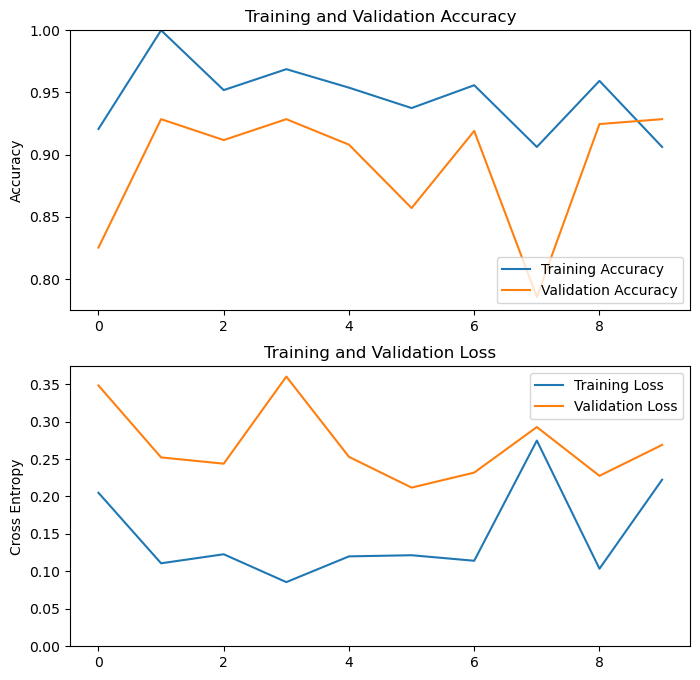

In [22]:
# Importing Libraries
from tensorflow import keras
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("ignore")

# Base Path for all files
data_dir = '/Users/dev/Downloads/Archive (2)'  # Update this to your dataset path

# Load Images For Training & Testing
datagenerator = {
    "train": ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1. / 255,
        validation_split=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rotation_range=30
    ).flow_from_directory(
        directory=data_dir,
        target_size=(256, 256),
        subset='training',
        class_mode='categorical'  # Use categorical for multiple classes
    ),
    "valid": ImageDataGenerator(
        rescale=1 / 255,
        validation_split=0.1
    ).flow_from_directory(
        directory=data_dir,
        target_size=(256, 256),
        subset='validation',
        class_mode='categorical'
    ),
}

# Initialize Densenet-121 Pretrained Model
base_model = DenseNet121(weights=None, include_top=False, input_shape=(256, 256, 3))

# Load Weights for the DenseNet-121 Model
base_model.load_weights('/Users/dev/Downloads/DenseNet-BC-121 no top.h5')  # Update to the correct path

# Setting the Training of all layers of the model to false
base_model.trainable = False

# Add Custom Layer
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax')  # 2 Output Neurons for 'normal' and 'lumpy'
])

# Compile the model with Adam optimizer
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

# Model Training Parameters
batch_size = 32
epochs = 10
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

# File Path to store the trained models
filepath = "/Users/dev/Desktop/lumpy skin/model_{epoch:02d}-{val_accuracy:.2f}.keras"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Training the Model
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint1]
)

# Model Evaluation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

# Load the best model based on the filepath
def load_best_model(filepath):
    # Find the best model file based on saved files
    model_dir = os.path.dirname(filepath)
    saved_files = os.listdir(model_dir)
    best_model_file = max(saved_files, key=lambda f: os.path.getmtime(os.path.join(model_dir, f)))
    best_model_path = os.path.join(model_dir, best_model_file)
    return keras.models.load_model(best_model_path)

loaded_best_model = load_best_model(filepath)

# Custom function to load and predict label for the image
def predict(img_rel_path):
    img = image.load_img(img_rel_path, target_size=(256, 256))
    img = image.img_to_array(img) / 255.0  # Normalize the image

    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img)
    plt.show()

    p = loaded_best_model.predict(img[np.newaxis, ...])
    labels = {0: 'Lumpy Skin', 1: 'Normal Skin'}

    print("\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n")

    classes = []
    prob = []
    print("\n-------------------Individual Probability--------------------------------\n")
    for i, j in enumerate(p[0]):
        print(labels[i].upper(), ':', round(j * 100, 2), '%')
        classes.append(labels[i])
        prob.append(round(j * 100, 2))

    def plot_bar_x():
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for Loaded Image')
        plt.show()

    plot_bar_x()


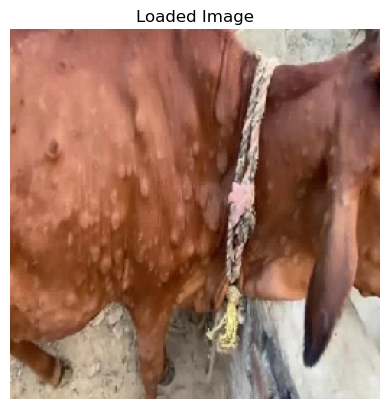

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Maximum Probability:  0.99316204
Classified: Lumpy Skin 


-------------------Individual Probability--------------------------------

LUMPY SKIN : 99.32 %
NORMAL SKIN : 0.68 %


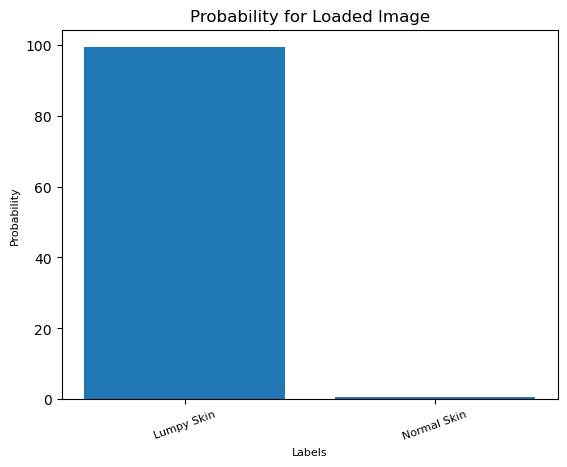

In [23]:
predict('/Users/dev/Downloads/Archive (2)/infected/infected (103).png')  # Update to the path of the image you want to predict

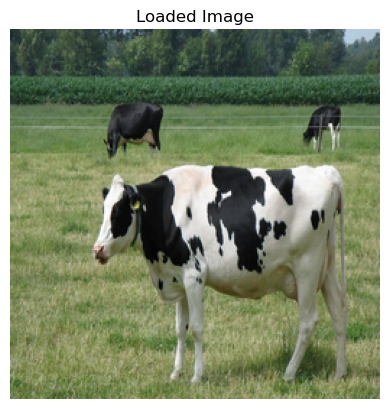

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

Maximum Probability:  0.9994667
Classified: Normal Skin 


-------------------Individual Probability--------------------------------

LUMPY SKIN : 0.05 %
NORMAL SKIN : 99.95 %


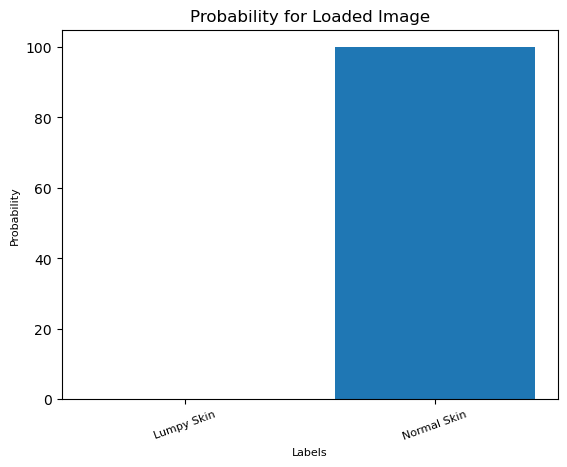

In [24]:
predict('/Users/dev/Desktop/lumpy skin/check/Normal_Skin_96.png')  # Update to the path of the image you want to predict

In [25]:
# Compile the model with Adam optimizer
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,089,154 (30.86 MB)

 Trainable params: 1,051,650 (4.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step 


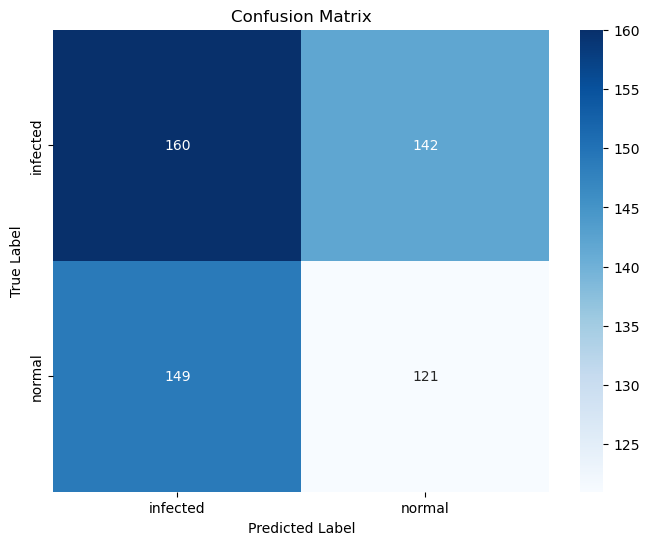

Classification Report:
              precision    recall  f1-score   support

    infected       0.52      0.53      0.52       302
      normal       0.46      0.45      0.45       270

    accuracy                           0.49       572
   macro avg       0.49      0.49      0.49       572
weighted avg       0.49      0.49      0.49       572

Overall Precision: 0.49
Overall Recall: 0.49
Overall F1 Score: 0.49


In [26]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Predictions on validation data
y_pred = model.predict(valid_generator)  # Predict probabilities for validation data
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class predictions
y_true = valid_generator.classes  # True labels for validation data

# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=valid_generator.class_indices.keys(), 
            yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 2. Classification Report (Precision, Recall, F1-Score, Accuracy per class)
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=valid_generator.class_indices.keys()))

# 3. Precision, Recall, and F1 Score (Overall Metrics)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Overall Precision: {precision:.2f}")
print(f"Overall Recall: {recall:.2f}")
print(f"Overall F1 Score: {f1:.2f}")


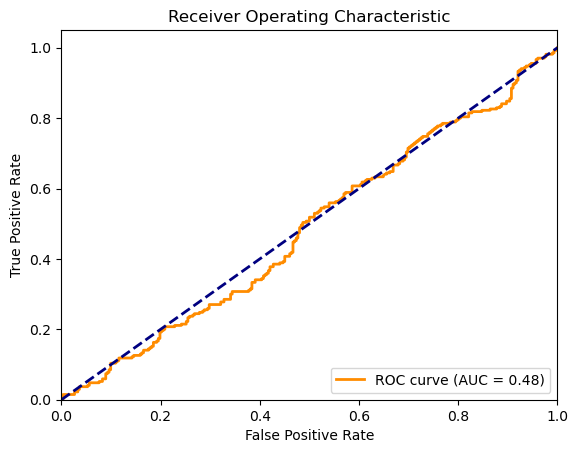

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels for multi-class ROC calculation
y_true_bin = label_binarize(y_true, classes=[0, 1])  # Adjust classes if needed
y_pred_bin = y_pred[:, 1]  # Prediction scores for class '1'

# Calculate ROC curve and AUC score for each class
fpr, tpr, _ = roc_curve(y_true_bin, y_pred_bin)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


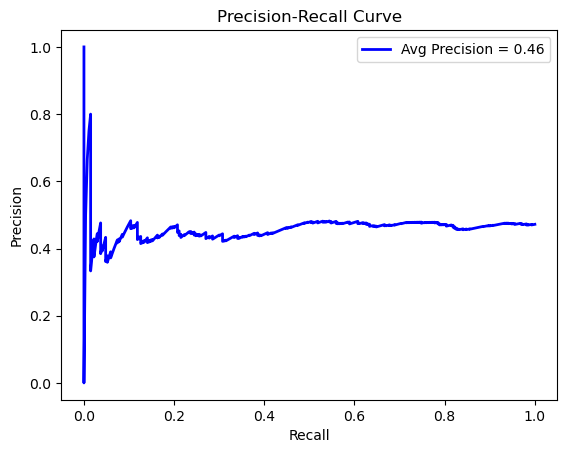

In [28]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_true_bin, y_pred_bin)
avg_precision = average_precision_score(y_true_bin, y_pred_bin)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


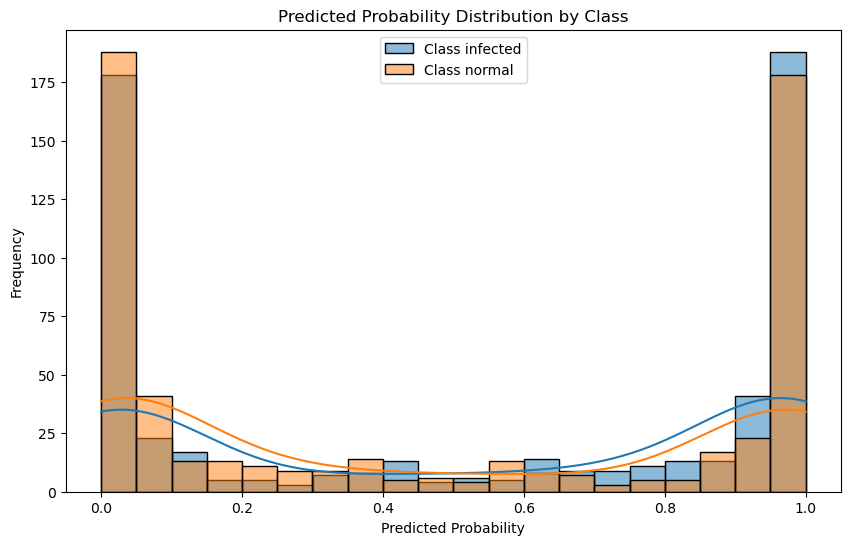

In [29]:
import seaborn as sns

# Get probabilities for each class
y_pred_probs = y_pred

plt.figure(figsize=(10, 6))
for i, class_name in enumerate(valid_generator.class_indices.keys()):
    sns.histplot(y_pred_probs[:, i], bins=20, kde=True, label=f'Class {class_name}')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Predicted Probability Distribution by Class')
plt.legend()
plt.show()


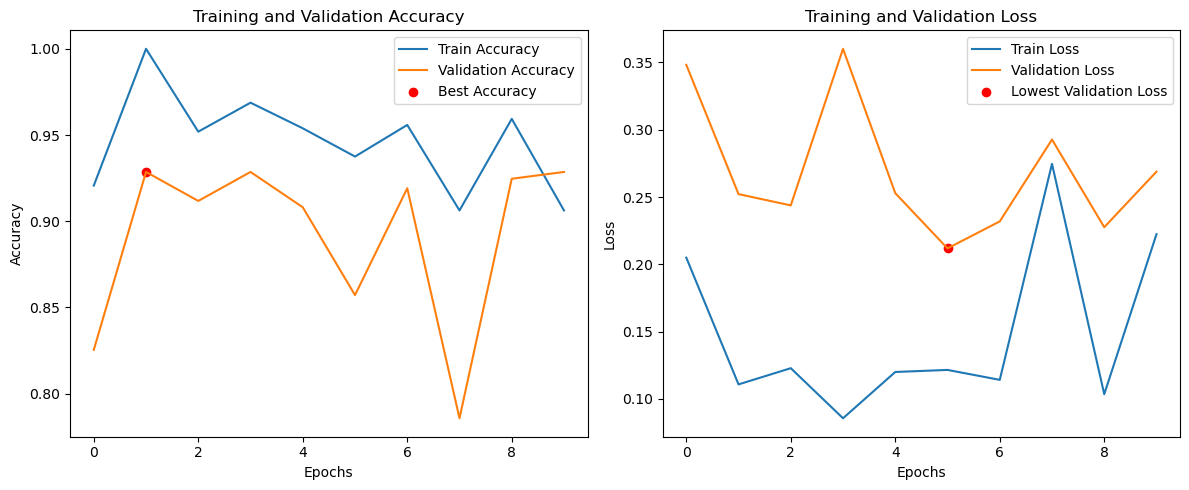

In [30]:
plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.scatter(np.argmax(history.history['val_accuracy']), max(history.history['val_accuracy']),
            label="Best Accuracy", color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.scatter(np.argmin(history.history['val_loss']), min(history.history['val_loss']),
            label="Lowest Validation Loss", color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


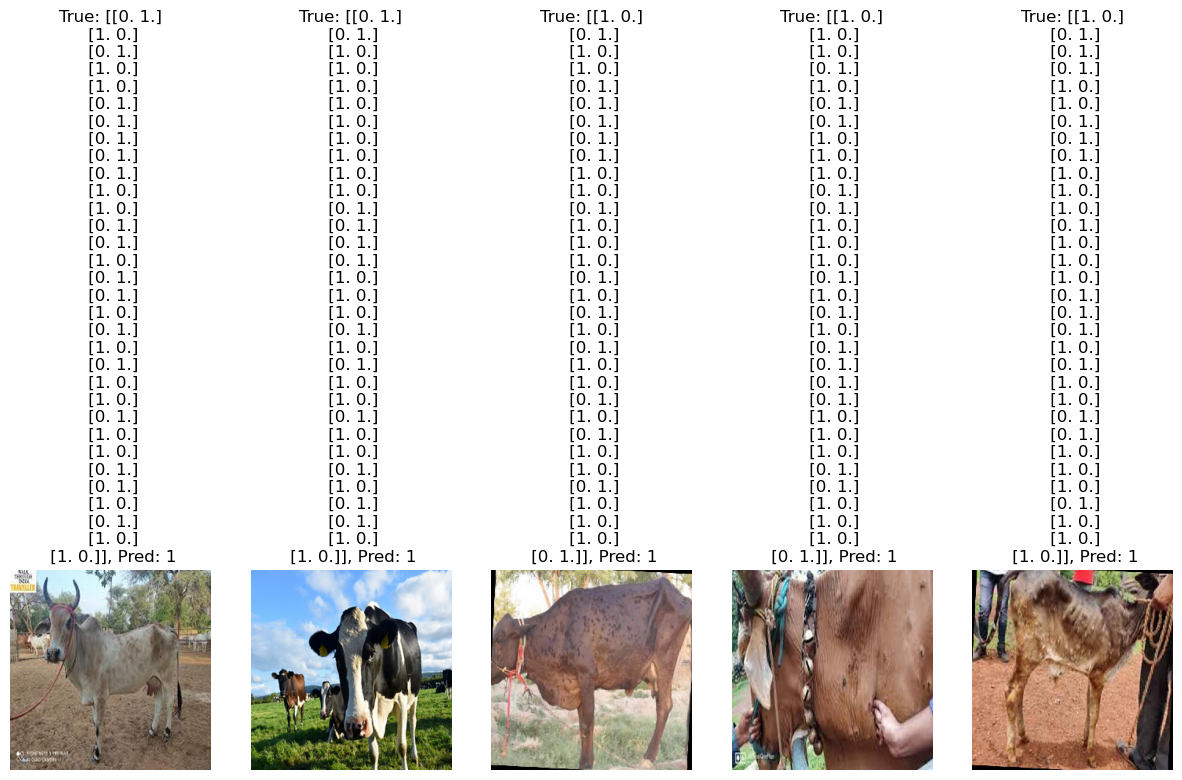

In [31]:
# Find misclassified samples
misclassified_indices = np.where(y_true != y_pred_classes)[0]
sample_size = min(5, len(misclassified_indices))  # Adjust sample size as desired

plt.figure(figsize=(15, 5))
for i, index in enumerate(misclassified_indices[:sample_size]):
    img, true_label = valid_generator[index]
    pred_label = y_pred_classes[index]

    plt.subplot(1, sample_size, i + 1)
    plt.imshow(img[0])
    plt.title(f'True: {true_label}, Pred: {pred_label}')
    plt.axis('off')
plt.show()


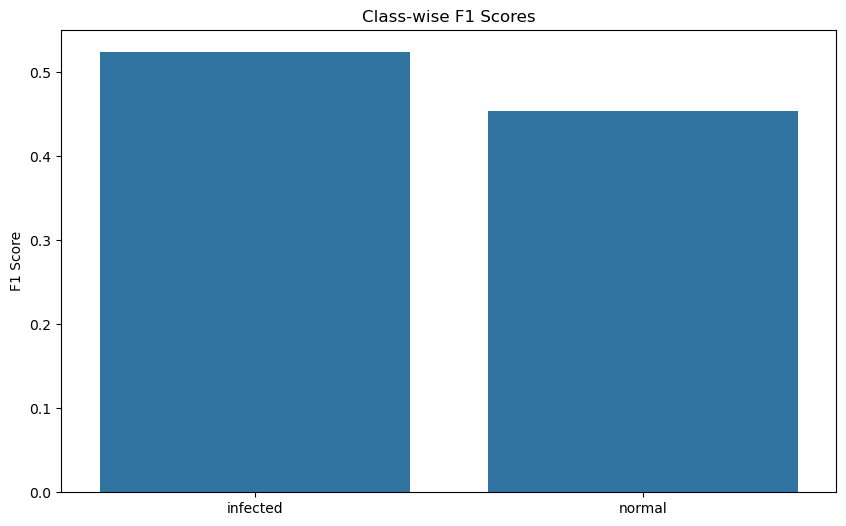

In [32]:
class_f1_scores = f1_score(y_true, y_pred_classes, average=None)
classes = list(valid_generator.class_indices.keys())

plt.figure(figsize=(10, 6))
sns.barplot(x=classes, y=class_f1_scores)
plt.ylabel('F1 Score')
plt.title('Class-wise F1 Scores')
plt.show()


Found 922 images belonging to 2 classes.
Found 102 images belonging to 2 classes.
Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.6801 - loss: 0.6256
Epoch 1: val_accuracy improved from -inf to 0.86458, saving model to /Users/dev/Desktop/lumpy_skin_best_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.6810 - loss: 0.6237 - val_accuracy: 0.8646 - val_loss: 0.3341
Epoch 2/15
 1/28 ━━━━━━━━━━━━━━━━━━━━ 23s 885ms/step - accuracy: 0.8750 - loss: 0.4914
Epoch 2: val_accuracy did not improve from 0.86458
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8750 - loss: 0.4914 - val_accuracy: 0.8333 - val_loss: 0.2766
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.8420 - loss: 0.4093
Epoch 3: val_accuracy improved from 0.86458 to 0.88542, saving model to /Users/dev/Desktop/lumpy_skin_best_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 943ms/step - accuracy: 0.8419 - loss: 0.4085 - val_accuracy: 0.8854 - val_loss: 0.2823
Epoch 4/15
 1/28 ━━━━━━━

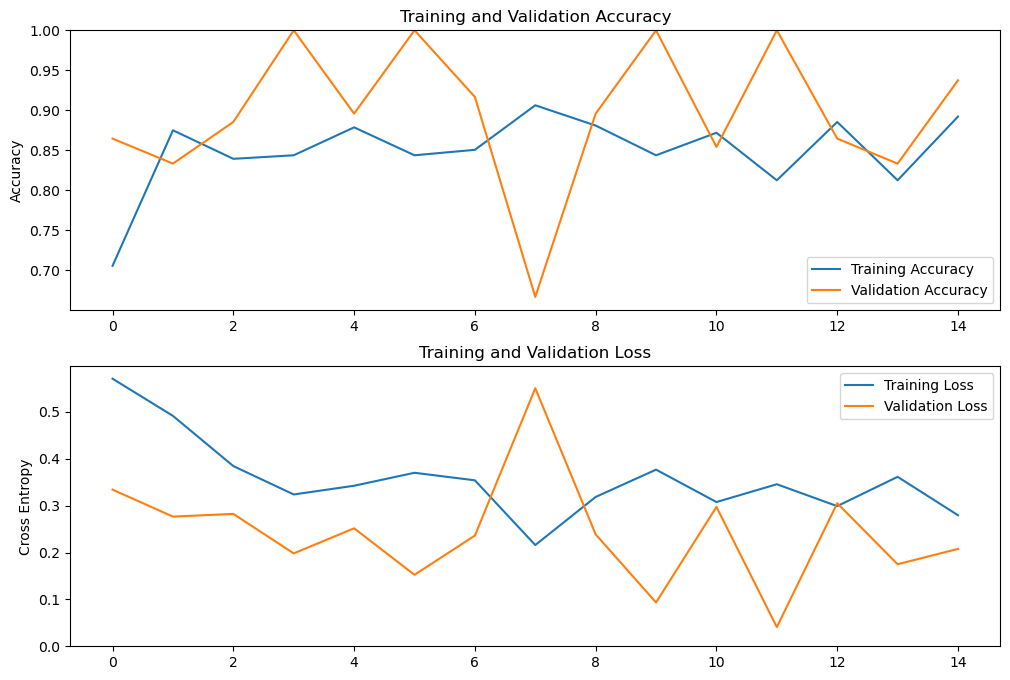

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step  
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.28      0.32        32
           1       0.71      0.79      0.74        70

    accuracy                           0.63       102
   macro avg       0.54      0.53      0.53       102
weighted avg       0.60      0.63      0.61       102



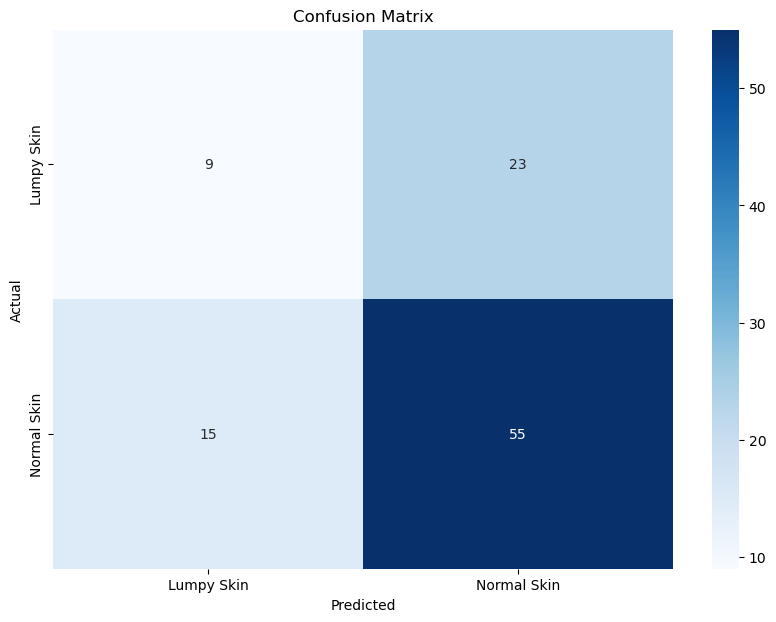

In [35]:
# Importing Libraries
from tensorflow import keras
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")

# Base Path for all files
data_dir = '/Users/dev/Downloads/Lumpy Skin Images Dataset'  # Update this to your dataset path

# Load Images For Training & Testing
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='training',
                                                     class_mode='categorical'),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='validation',
                                                     class_mode='categorical'),
}

# Initialize Densenet-121 Pretrained Model
base_model = DenseNet121(weights=None, include_top=False, input_shape=(256, 256, 3))

# Load Weights for the DenseNet-121 Model
base_model.load_weights('/Users/dev/Downloads/DenseNet-BC-121 no top.h5')  # Update to the correct path

# Setting the Training of all layers of the model to false
base_model.trainable = False

# Add Custom Layer
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax')  # 2 Output Neurons for 'normal' and 'lumpy'
])

# Compile the model with Adam optimizer
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

# Model Training Parameters
batch_size = 32
epochs = 15
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

# File Path to store the trained model (static name)
checkpoint_filepath = "/Users/dev/Desktop/lumpy_skin_best_model.keras"  # Update this with a static name
checkpoint1 = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Training the Model
history = model.fit(
    train_generator, 
    epochs=epochs, 
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator, 
    validation_steps=validation_steps,
    callbacks=[checkpoint1]
)

# Model Evaluation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(12, 8))

# Accuracy Plot
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

# Loss Plot
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

# Load the Best Model for Evaluation
loaded_best_model = keras.models.load_model(checkpoint_filepath)

# Predict on Validation Set and Display Confusion Matrix
Y_pred = loaded_best_model.predict(valid_generator)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = valid_generator.classes

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=valid_generator.class_indices, yticklabels=valid_generator.class_indices)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Custom function to load and predict label for a single image
def predict(img_rel_path):
    img = image.load_img(img_rel_path, target_size=(256, 256))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img) / 255.0

    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    p = loaded_best_model.predict(img[np.newaxis, ...])
    labels = {0: 'Lumpy Skin', 1: 'Normal Skin'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes = []
    prob = []
    print("\n-------------------Individual Probability--------------------------------\n")
    for i, j in enumerate(p[0], 0):
        print(labels[i].upper(), ':', round(j * 100, 2), '%')
        classes.append(labels[i])
        prob.append(round(j * 100, 2))

    # Bar plot for probabilities
    def plot_bar_x():
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    
    plot_bar_x()

# Example usage
# predict('path/to/your/image.jpg')  # Update to the path of the image you want to predict


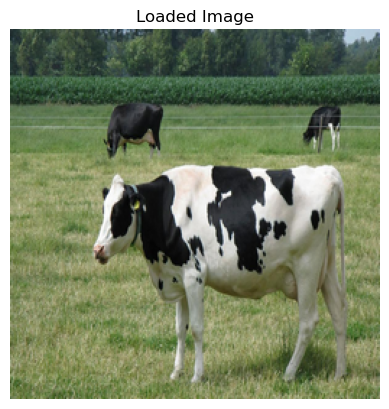

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Maximum Probability:  0.9882604
Classified: Normal Skin 



-------------------Individual Probability--------------------------------

LUMPY SKIN : 1.17 %
NORMAL SKIN : 98.83 %


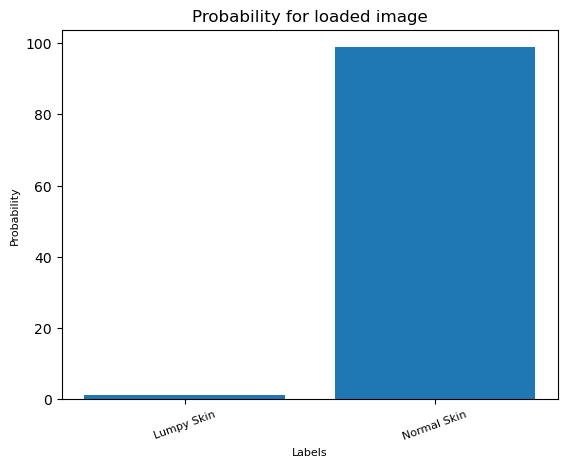

In [43]:
predict('/Users/dev/Desktop/lumpy skin/check/Normal_Skin_96.png')  # Update to the path of the image you want to predict

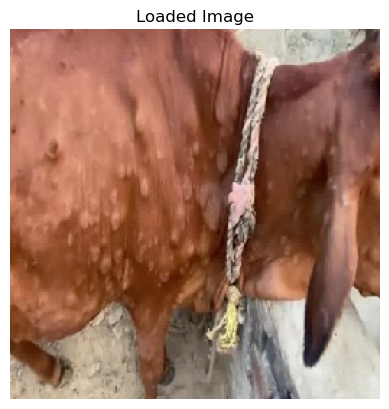

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Maximum Probability:  0.9375059
Classified: Lumpy Skin 



-------------------Individual Probability--------------------------------

LUMPY SKIN : 93.75 %
NORMAL SKIN : 6.25 %


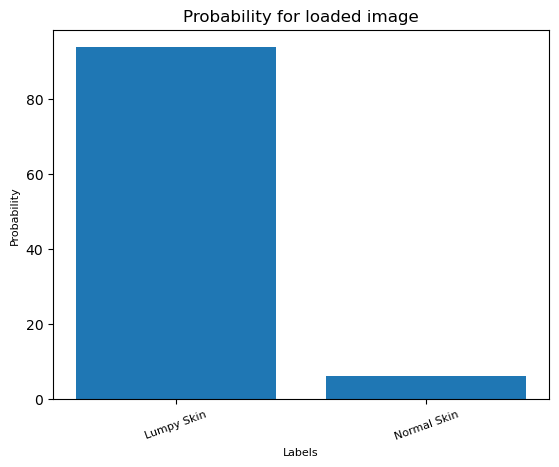

In [37]:
predict('/Users/dev/Downloads/Archive (2)/infected/infected (103).png')  # Update to the path of the image you want to predict

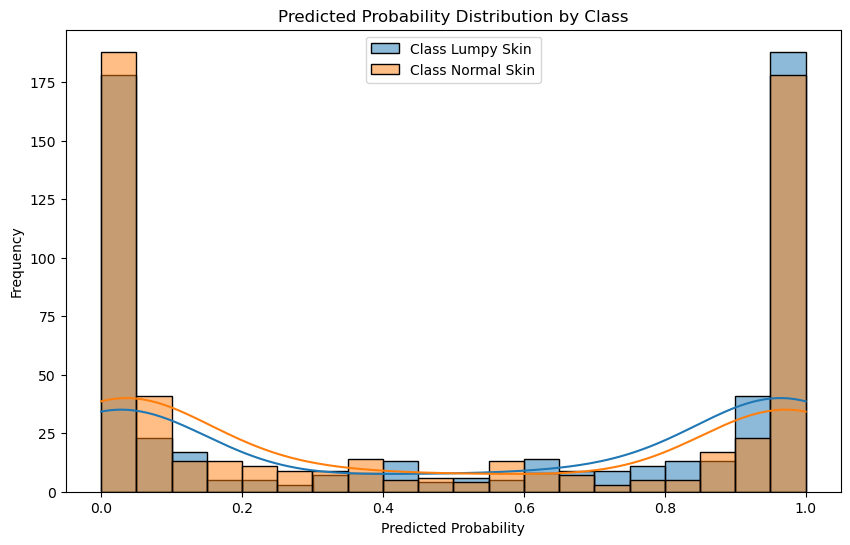

In [40]:
import seaborn as sns

# Get probabilities for each class
y_pred_probs = y_pred

plt.figure(figsize=(10, 6))
for i, class_name in enumerate(valid_generator.class_indices.keys()):
    sns.histplot(y_pred_probs[:, i], bins=20, kde=True, label=f'Class {class_name}')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Predicted Probability Distribution by Class')
plt.legend()
plt.show()


In [42]:
# Compile the model with Adam optimizer
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,089,154 (30.86 MB)

 Trainable params: 1,051,650 (4.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)